# **Capacitated Vehicle Routing Problem with Time Windows**

A Capacitated Vehicle Routing Problem with Time Windows (CVRPTW) needs to be solved for a fleet of vehicles servicing several customers in Cagayan de Oro City. The objective is to determine the optimal routes for the vehicles while minimizing the total travel time for all vehicles, ensuring that each vehicle:

- Visits each customer exactly once.
  
- Adheres to the service time and time window constraints for each customer.
  
- Does not exceed the vehicle capacity, considering customer demands.

### PART 1 : Import Libraries and Data Collection

#### Import Neccessary Libraries

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np
import json
from datetime import timedelta

# Geospatial Analysis
import geopandas as gpd
import osmnx as ox
import networkx as nx
from shapely.geometry import LineString
from shapely.geometry import MultiLineString

# Visualization
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

# Optimization
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

#### Load Location Data and Retrieve OpenStreetMap for "Cagayan de Oro City"

In [2]:
# Load location data
json_filepath = "location_data.json"
with open(json_filepath,'r') as file: 
    data = json.load(file)

vrp_data = data

# Retrieve OpenStreetMap for "Cagayan de Oro City"
place_name = 'Cagayan de Oro City'
graph = ox.graph_from_place(place_name, network_type = 'all')

# Extract the nodes and edges of the graph
nodes, edges = ox.graph_to_gdfs(graph)

# Ensure coordinate refercence sytem is EPSG: 3857 (length in meters(m))
nodes = nodes.to_crs('EPSG:3857')
edges = edges.to_crs('EPSG:3857')


### PART 2 : Data Cleaning and Preprocessing

#### Data Cleaning - Edges

In [3]:
# Inspect edges information
edges.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 42814 entries, (282290867, 8735875602, 0) to (12420181269, 4483167323, 0)
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   osmid     42814 non-null  object  
 1   oneway    42814 non-null  bool    
 2   lanes     8612 non-null   object  
 3   ref       1774 non-null   object  
 4   name      10968 non-null  object  
 5   highway   42814 non-null  object  
 6   maxspeed  2995 non-null   object  
 7   reversed  42814 non-null  object  
 8   length    42814 non-null  float64 
 9   geometry  42814 non-null  geometry
 10  bridge    245 non-null    object  
 11  access    2951 non-null   object  
 12  junction  191 non-null    object  
 13  service   773 non-null    object  
 14  tunnel    10 non-null     object  
 15  width     10 non-null     object  
dtypes: bool(1), float64(1), geometry(1), object(13)
memory usage: 6.4+ MB


In [4]:
# Create a GeoDataFrame with the relevant columns only
network_edges = edges[['osmid','name','oneway','highway','maxspeed','reversed','length','geometry']]
network_edges.reset_index(inplace = True)
network_edges.head()

,u,v,key,osmid,name,oneway,highway,maxspeed,reversed,length,geometry
0,282290867,8735875602,0,142770376,C. M. Recto Avenue,False,trunk,60,True,32.752,"LINESTRING (13887538.04 950614.616, 13887550.4..."
1,282290867,7690137731,0,1159126528,NaN,False,service,NaN,True,22.036,"LINESTRING (13887538.04 950614.616, 13887517.0..."
2,282290867,1068803033,0,142770376,C. M. Recto Avenue,False,trunk,60,False,39.185,"LINESTRING (13887538.04 950614.616, 13887532.4..."
3,282290875,8730016788,0,142770376,C. M. Recto Avenue,False,trunk,60,False,8.025,"LINESTRING (13887401.173 950012.096, 13887395...."
4,282290875,8730044271,0,142770376,C. M. Recto Avenue,False,trunk,60,True,73.154,"LINESTRING (13887401.173 950012.096, 13887438...."


In [5]:
# Split rows with multiple values in highway column
network_edges_exploded = network_edges.explode('highway')

# Show unique values for highway column
unique_highway_types = network_edges_exploded['highway'].unique()
unique_highway_types

array(['trunk', 'service', 'residential', 'secondary', 'tertiary',
       'primary', 'unclassified', 'path', 'primary_link', 'track',
       'tertiary_link', 'footway', 'trunk_link', 'steps', 'pedestrian',
       'secondary_link', 'corridor'], dtype=object)

In [6]:
# Select the roads that are suitable only for truck travel
suitable_roads = [
    'primary', 'primary_link', 'secondary', 'secondary_link', 
    'tertiary', 'tertiary_link', 'trunk', 'trunk_link'  
]
# Filter the network_edges to keep only rows with suitable roads
network_edges = network_edges[network_edges['highway'].isin(suitable_roads)]

In [7]:
# Check other columns if it has multiple values also
column_info = pd.Series({
    col: {
        "Data Type": network_edges[col].dtype,
        "Contains Lists": any(network_edges[col].apply(lambda x: isinstance(x, list)))
    }
    for col in network_edges.columns
})

column_info

u              {'Data Type': int64, 'Contains Lists': False}
v              {'Data Type': int64, 'Contains Lists': False}
key            {'Data Type': int64, 'Contains Lists': False}
osmid          {'Data Type': object, 'Contains Lists': True}
name           {'Data Type': object, 'Contains Lists': True}
oneway          {'Data Type': bool, 'Contains Lists': False}
highway       {'Data Type': object, 'Contains Lists': False}
maxspeed       {'Data Type': object, 'Contains Lists': True}
reversed       {'Data Type': object, 'Contains Lists': True}
length       {'Data Type': float64, 'Contains Lists': False}
geometry    {'Data Type': geometry, 'Contains Lists': False}
dtype: object

In [8]:
# For multiple values in the osmid and name column extract only the first value of the list
def extract_first_value(x):
    return x[0] if isinstance(x, list) and len(x) > 0 else x

columns_to_extract = ['osmid', 'name']

for col in columns_to_extract:
    network_edges[col] = network_edges[col].apply(extract_first_value)

# For multiple values in the reversed column simply explode the geodataframe
network_edges = network_edges.explode('reversed')

# Convert some columns to proper datatypes
network_edges['maxspeed'] = pd.to_numeric(network_edges['maxspeed'], errors='coerce', downcast='float')
network_edges['reversed'] = network_edges['reversed'].astype(bool)

network_edges.head()

,u,v,key,osmid,name,oneway,highway,maxspeed,reversed,length,geometry
0,282290867,8735875602,0,142770376,C. M. Recto Avenue,False,trunk,60.0,True,32.752,"LINESTRING (13887538.04 950614.616, 13887550.4..."
2,282290867,1068803033,0,142770376,C. M. Recto Avenue,False,trunk,60.0,False,39.185,"LINESTRING (13887538.04 950614.616, 13887532.4..."
3,282290875,8730016788,0,142770376,C. M. Recto Avenue,False,trunk,60.0,False,8.025,"LINESTRING (13887401.173 950012.096, 13887395...."
4,282290875,8730044271,0,142770376,C. M. Recto Avenue,False,trunk,60.0,True,73.154,"LINESTRING (13887401.173 950012.096, 13887438...."
6,282305245,4698476816,0,476216056,General Capistrano Street,False,secondary,NaN,True,64.430,"LINESTRING (13875408.568 947911.559, 13875450...."


In [9]:
# Count the null values for each column
null_count = network_edges.isnull().sum()
null_count

u              0
v              0
key            0
osmid          0
name        1119
oneway         0
highway        0
maxspeed    4045
reversed       0
length         0
geometry       0
dtype: int64

In [10]:
# For missing values in the name column replace the null values with 'unknown'
network_edges['name'] = network_edges['name'].fillna('unknown')

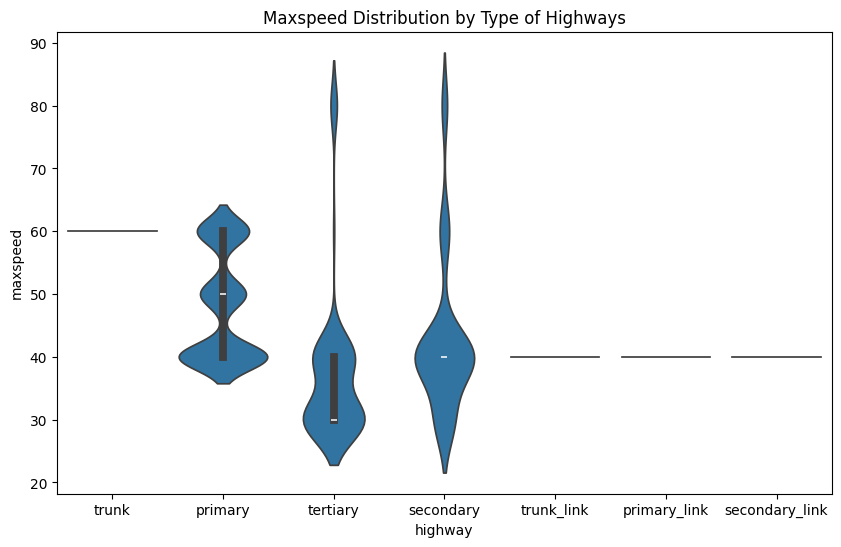

In [11]:
# For missing values in the maxspeed column, create a plot to visualize maxspeed distribution by highway type
plt.figure(figsize=(10, 6))
sns.violinplot(x='highway', y='maxspeed', data=network_edges.dropna(subset='maxspeed'))
plt.title('Maxspeed Distribution by Type of Highways')
plt.show()

In [12]:
# Impute the missing values for maxspeed based on the following condition observed from the violin plot
'''
If maxspeed is missing and:
    - The road is a primary and trunk it sets maxspeed to 60.
    - The road is a primary_link, secondary_link, trunk_link, and secondary it sets maxspeed to 40.
    - The road is a tertiary it sets maxspeed to 30.
    - If none of these apply, it keeps the existing maxspeed value.
'''

network_edges['maxspeed'] = network_edges.apply(
    lambda row: (
        60 if pd.isna(row['maxspeed']) and row['highway'] in ['primary', 'trunk'] else
        40 if pd.isna(row['maxspeed']) and row['highway'] in ['primary_link', 'secondary_link', 'trunk_link', 'secondary'] else
        30 if pd.isna(row['maxspeed']) and row['highway'] == 'tertiary' else
        row['maxspeed']
    ),
    axis=1
)

# Add the minute column as the cost of travelling from node to node
network_edges['minutes'] = network_edges['length'] / (network_edges['maxspeed'] * 1000 / 60)

# Drop any remaining rows that contain null values
network_edges = network_edges.dropna()

network_edges.head()

,u,v,key,osmid,name,oneway,highway,maxspeed,reversed,length,geometry,minutes
0,282290867,8735875602,0,142770376,C. M. Recto Avenue,False,trunk,60.0,True,32.752,"LINESTRING (13887538.04 950614.616, 13887550.4...",0.032752
2,282290867,1068803033,0,142770376,C. M. Recto Avenue,False,trunk,60.0,False,39.185,"LINESTRING (13887538.04 950614.616, 13887532.4...",0.039185
3,282290875,8730016788,0,142770376,C. M. Recto Avenue,False,trunk,60.0,False,8.025,"LINESTRING (13887401.173 950012.096, 13887395....",0.008025
4,282290875,8730044271,0,142770376,C. M. Recto Avenue,False,trunk,60.0,True,73.154,"LINESTRING (13887401.173 950012.096, 13887438....",0.073154
6,282305245,4698476816,0,476216056,General Capistrano Street,False,secondary,40.0,True,64.430,"LINESTRING (13875408.568 947911.559, 13875450....",0.096645


#### Data Cleaning - Nodes

In [13]:
# Inspect nodes information
nodes.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 17434 entries, 282290867 to 12420181269
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   y             17434 non-null  float64 
 1   x             17434 non-null  float64 
 2   street_count  17434 non-null  int64   
 3   highway       212 non-null    object  
 4   geometry      17434 non-null  geometry
dtypes: float64(2), geometry(1), int64(1), object(1)
memory usage: 817.2+ KB


In [14]:
# Create a Geodataframe with the relevant columns only
network_nodes = nodes[['y','x','street_count','geometry']]
network_nodes.reset_index(inplace = True)

# Select only the nodes from network_nodes that appear in network_edges
edges_nodes = pd.DataFrame({'osmid': pd.unique(network_edges[['u', 'v']].values.ravel())})
network_nodes = network_nodes[network_nodes['osmid'].isin(edges_nodes['osmid'])]

network_nodes.head()

,osmid,y,x,street_count,geometry
0,282290867,8.508075,124.753877,3,POINT (13887538.04 950614.616)
1,282290875,8.502722,124.752647,3,POINT (13887401.173 950012.096)
2,282305245,8.484060,124.644916,3,POINT (13875408.568 947911.559)
3,282305248,8.483482,124.644493,4,POINT (13875361.48 947846.538)
4,282305251,8.477963,124.642426,4,POINT (13875131.371 947225.43)


#### Prepare VRP Data with Cost Matrix

In [15]:
# Define a function with Haversine Formula to calculate the distance from a location to a node
def haversine_np(lon1, lat1, lon2, lat2):
    R = 6371 # Earth radius in kilometers

    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Define a function to locate the closest osmids using the haversine_np function
def find_closest_osmids(places, network_nodes):
    osmids = []

    for location, coordinates in zip(vrp_data['location'], vrp_data['coordinates']):
        lat, lon = coordinates

        # Calculate the distances
        network_nodes['distance'] = haversine_np(network_nodes['x'], network_nodes['y'], lon, lat)

        # Find the closest osmid
        closest_osmid = network_nodes.loc[network_nodes['distance'].idxmin(), 'osmid']
        osmids.append(closest_osmid)

    return osmids

# Return the closest osmids
closest_osmids = find_closest_osmids(vrp_data, network_nodes)
closest_osmids

[1496033167, 7654479457, 7934267325, 3610120179, 6829747942, 7655536651]

In [16]:
# Initialize the cost_matrix to store travel time between locations
n = len(closest_osmids)
cost_matrix = np.zeros((n, n))

# Populate cost_matrix with the shortest_path_lenght between locations
for i, osmid1 in enumerate(closest_osmids):
    for j, osmid2 in enumerate(closest_osmids):
        if i != j:
            try:
                cost = nx.shortest_path_length(
                    graph, source=osmid1, target=osmid2, weight='minutes'
                )
            except nx.NetworkXNoPath:
                cost = float('inf')
        else:
            cost = 0
        cost_matrix[i, j] = cost

# Update vrp_data with the closest_osmids and cost_matrix
vrp_data.update({'closest_osmids': closest_osmids, 'cost_matrix': cost_matrix.tolist()})
vrp_data

{'location': ['Depot',
  'Customer_1',
  'Customer_2',
  'Customer_3',
  'Customer_4',
  'Customer_5'],
 'coordinates': [[8.47170604497651, 124.710365824859],
  [8.457181507260465, 124.62346290057478],
  [8.3016207395089, 124.538743594807],
  [8.33732786142426, 124.468369729278],
  [8.50439684448023, 124.626499027424],
  [8.50013824835117, 124.751709059623]],
 'demands': [0, 30, 30, 35, 35, 30],
 'service_times': [0, 30, 30, 30, 30, 30],
 'vehicle_capacities': [70, 50, 70],
 'num_vehicles': 3,
 'depot': 0,
 'time_windows': [[480, 1020],
  [480, 1020],
  [480, 1020],
  [480, 1020],
  [480, 1020],
  [480, 1020]],
 'closest_osmids': [1496033167,
  7654479457,
  7934267325,
  3610120179,
  6829747942,
  7655536651],
 'cost_matrix': [[0.0, 113.0, 164.0, 182.0, 121.0, 126.0],
  [115.0, 0.0, 96.0, 114.0, 60.0, 241.0],
  [164.0, 99.0, 0.0, 44.0, 151.0, 290.0],
  [182.0, 117.0, 44.0, 0.0, 167.0, 308.0],
  [120.0, 62.0, 146.0, 164.0, 0.0, 246.0],
  [128.0, 241.0, 292.0, 310.0, 249.0, 0.0]]}

### PART 3 : Optimization Model and Solution

#### Create the Routing Model and Register Functions

In [17]:
# Create the Routing Model
manager = pywrapcp.RoutingIndexManager(len(vrp_data['cost_matrix']), vrp_data['num_vehicles'], vrp_data['depot'])
routing = pywrapcp.RoutingModel(manager)

# Define a function to calculate the travel time between two nodes, incorporating service time
def time_callback(from_index, to_index):
    from_node, to_node = manager.IndexToNode(from_index), manager.IndexToNode(to_index)
    travel_time = vrp_data['cost_matrix'][from_node][to_node] + (
        vrp_data['service_times'][from_node] if from_node != vrp_data['depot'] else 0
    )
    return travel_time

# Register time_callback
transit_callback_index = routing.RegisterTransitCallback(time_callback)

# Define a function to get the demand for each location
def demand_callback(from_index):
    return vrp_data['demands'][manager.IndexToNode(from_index)]

# Register demand callback
demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)

# Set cost function based on the travel time between two nodes
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

#### Add Constraints to the Routing Model

In [18]:
# Add capacity constraints to Routing Model
routing.AddDimensionWithVehicleCapacity(
    demand_callback_index,
    0, # No Extra Capacity
    vrp_data['vehicle_capacities'],
    True,
    'Capacity'
)

# Add time windows constraint to Routing Model
routing.AddDimension(
    transit_callback_index,
    30, # 30 minutes slack time
    540,  # Total available minutes from 8 AM to 5 PM (9 hours = 540 minutes)
    False,
    'Time'
)

# Get the time dimension
time_dimension = routing.GetDimensionOrDie('Time')

# Enforce arrival time for each location (except the depot)
for location_idx, time_window in enumerate(vrp_data['time_windows']):
    if location_idx == vrp_data['depot']:
        continue
    index = location_idx
    time_dimension.CumulVar(index).SetRange(time_window[0], time_window[1])

# Ensure the vehicle must depart at the specified time window of plant
for vehicle_id in range(vrp_data['num_vehicles']):
    index = routing.Start(vehicle_id)
    time_dimension.CumulVar(index).SetRange(
        vrp_data['time_windows'][vrp_data['depot']][0], vrp_data['time_windows'][vrp_data['depot']][1]
    )

#### Solve the Vehicle Routing Problem

In [19]:
# Create a default set of routing search parameters
search_params = pywrapcp.DefaultRoutingSearchParameters()

# Set the strategy for finding the first solution: 'PATH_CHEAPEST_ARC'
search_params.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
)

# Solve the routing problem using the defined search parameters
solution = routing.SolveWithParameters(search_params)

### PART 4 : Results Overview and Visualization

#### Define a function to display the result overview

In [20]:
# Define a function to convert minutes to hh:mm format
def format_time(minutes):
    hours, minutes = divmod(minutes, 60)
    return f"{int(hours):02}:{int(minutes):02}"
    
# Define a function to processes the results of a Vehicle Routing Problem (VRP) solution
def get_solution(data, manager, routing, solution, time_dimension):
    result = []
    
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        sequence = 0
        accumulated_time = 0  
        prev_node = None
        prev_departure_time = data['time_windows'][0][0]

        # Traverse the routes for each vehicle
        while not routing.IsEnd(index):
            node = manager.IndexToNode(index)
            
            # Calculate the cost between previous node and current node
            if prev_node is not None:
                cost = data['cost_matrix'][prev_node][node]
            else:
                cost = 0.0  # No cost for the first node
                
            service_time = data['service_times'][node]  # Service time for the current node

            # Calculate Arrival and Departure Times
            arrival_time = prev_departure_time + cost
            departure_time = arrival_time + service_time
            
            # Format times as hh:mm
            arrival_time_formatted = format_time(arrival_time)
            departure_time_formatted = format_time(departure_time)

            # Append node details for the vehicle
            result.append({
                'VehicleId': vehicle_id,
                'SequenceOfVisit': sequence,
                'Location': data['location'][node],
                'Osmid': data['closest_osmids'][node],
                'UnitsDemand': data['demands'][node],
                'TravelTime': cost,
                'ServiceTime': service_time,
                'EstimatedArrivalTime': arrival_time_formatted,
                'EstimatedDepartureTime': departure_time_formatted
            })
            
            # Update previous node and departure time for the next iteration
            prev_node = node
            prev_departure_time = departure_time
            sequence += 1

            # Move to the next index in the route
            index = solution.Value(routing.NextVar(index))

        # Handle the end node (return to depot or route termination)
        end_node = manager.IndexToNode(index)
        
        # Calculate cost and service time for the end node
        if prev_node is not None:
            cost = data['cost_matrix'][prev_node][end_node]  
        else:
            cost = 0.0  # No cost for the first node

        service_time = data['service_times'][end_node]  # Service time for the end node
        
        # Calculate Arrival and Departure Times for the end node
        arrival_time = prev_departure_time + cost
        departure_time = arrival_time + service_time

        # Format times as hh:mm
        arrival_time_formatted = format_time(arrival_time)
        departure_time_formatted = format_time(departure_time)

        # Append end node details
        result.append({
            'VehicleId': vehicle_id,
            'SequenceOfVisit': sequence,
            'Location': data['location'][end_node],
            'Osmid': data['closest_osmids'][end_node],
            'UnitsDemand': data['demands'][end_node],
            'TravelTime': cost,
            'ServiceTime': service_time,
            'EstimatedArrivalTime': arrival_time_formatted,
            'EstimatedDepartureTime': departure_time_formatted
        })
        
    # Convert result to a DataFrame
    df = pd.DataFrame(result)
    return df

vrp_solution = get_solution(vrp_data, manager, routing, solution, time_dimension)

#### Define a function to plot the VRP solution on a graph

In [21]:
# Get VRP solution
vrp_solution = get_solution(vrp_data, manager, routing, solution, time_dimension)

# Create dictionary of the routes with list of osmids visited
routes_dict = {}
for vehicle_id, group in vrp_solution.groupby('VehicleId'):
    routes_dict[vehicle_id] = group['Osmid'].tolist()

# Define a function to find the shortest path between locations
def find_shortest_path(G, start_node, end_node):
    shortest_path = nx.shortest_path(G, source=start_node, target=end_node, weight='minutes')
    return shortest_path

# Define a function to plot the VRP solution on a graph
def plot_vrp_solution(network_nodes, network_edges, routes_dict):
    # Create the directed graph
    G = nx.DiGraph()

    # Add nodes to the graph from the network_nodes DataFrame
    for _, row in network_nodes.iterrows():
        G.add_node(row['osmid'], y=row['y'], x=row['x'], street_count=row['street_count'], geometry=row['geometry'])

    # Add edges to the graph from the network_edges DataFrame
    for _, row in network_edges.iterrows():
        G.add_edge(row['u'], row['v'], weight=row['minutes'])

    # Create a figure for the plot
    plt.figure(figsize=(12, 10))

    # Set positions for the nodes based on their coordinates (x, y)
    pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

    # Plot the entire graph
    nx.draw(
        G, pos, 
        node_size=1, 
        edge_color='gray', 
        node_color='#bcbd22', 
        alpha=0.2, 
        with_labels=False, 
        arrows=False 
    )

    # Define a list of custom colors for different routes
    route_colors = [
        '#ff7f0e',  # Orange
        '#bcbd22',  # Olive
        '#9467bd',  # Pink
        '#e377c2',  # Purple
        '#1f77b4',  # Medium Blue
    ]

    # Create a legend list using Line2D for color matching
    route_labels = []
    legend_lines = []

    # Plot each route in the routes_dict
    for idx, (vehicle_id, osmids) in enumerate(routes_dict.items()):
        color = route_colors[idx % len(route_colors)]
        route_labels.append(f'Route {vehicle_id}')

        # Create a legend line matching the color
        legend_line = mlines.Line2D([], [], color=color, label=f'Route {vehicle_id}')
        legend_lines.append(legend_line)

        for i in range(len(osmids) - 1):
            start_node = osmids[i]
            end_node = osmids[i + 1]

            # Find the shortest path between the current start and end node
            shortest_path = find_shortest_path(G, start_node, end_node)
            
            # Plot the shortest path with the selected color
            path_edges = list(zip(shortest_path[:-1], shortest_path[1:]))
            nx.draw_networkx_edges(
                G, pos, 
                edgelist=path_edges, 
                edge_color=[color], 
                width=5, 
                alpha=0.5, 
                arrows=False
            )

            # Plot the nodes in the shortest path with the selected color
            nx.draw_networkx_nodes(
                G, pos, 
                nodelist=shortest_path, 
                node_size=0.0, 
                node_color=[color], 
                alpha=1.0
            )

            # Label nodes in the current route
            node_labels = {node: str(osmids.index(node)) for node in shortest_path if node in osmids}
            nx.draw_networkx_labels(
                G, pos, 
                labels=node_labels, 
                font_size=10, 
                font_color='white', 
                font_weight='bold', 
                verticalalignment='center'
            )

    # Highlight nodes for all customer locations with a distinct color (red)
    all_osmids = set([node for osmids in routes_dict.values() for node in osmids])
    nx.draw_networkx_nodes(
        G, pos, 
        nodelist=list(all_osmids), 
        node_size=200,  # Increase size to make the nodes more visible
        node_color='red', 
        alpha=1.0
    )

    # Add the legend using custom legend lines
    plt.legend(handles=legend_lines, title="Routes", loc='upper left')

    # Show plot with a title
    plt.title("Optimized Routes for Capacitated VRP with Time Windows")
    plt.show()

# **Vehicle Routing Problem (VRP) Solution on Graph** 


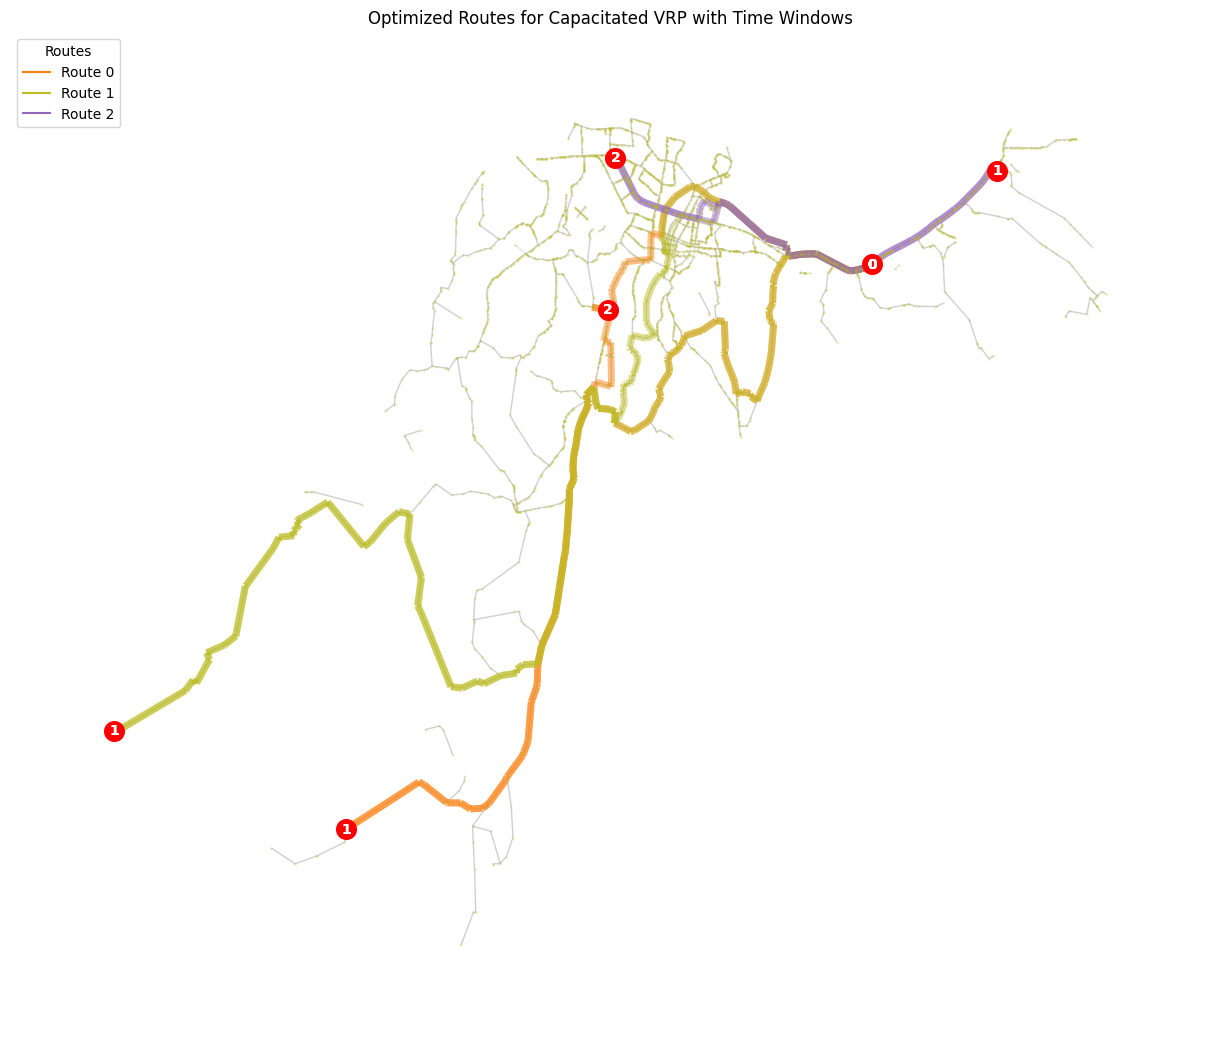

In [22]:
plot_vrp_solution(network_nodes, network_edges, routes_dict)

# **Results Overview** 


In [23]:
vrp_solution

,VehicleId,SequenceOfVisit,Location,Osmid,UnitsDemand,TravelTime,ServiceTime,EstimatedArrivalTime,EstimatedDepartureTime
0,0,0,Depot,1496033167,0,0.0,0,08:00,08:00
1,0,1,Customer_2,7934267325,30,164.0,30,10:44,11:14
2,0,2,Customer_1,7654479457,30,99.0,30,12:53,13:23
3,0,3,Depot,1496033167,0,115.0,0,15:18,15:18
4,1,0,Depot,1496033167,0,0.0,0,08:00,08:00
5,1,1,Customer_3,3610120179,35,182.0,30,11:02,11:32
6,1,2,Depot,1496033167,0,182.0,0,14:34,14:34
7,2,0,Depot,1496033167,0,0.0,0,08:00,08:00
8,2,1,Customer_5,7655536651,30,126.0,30,10:06,10:36
9,2,2,Customer_4,6829747942,35,249.0,30,14:45,15:15
